In [1]:
# You only need to run this once per machine
!pip install -q -U bitsandbytes datasets scipy ipywidgets
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cuml 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cuml 23.8.0 requires dask==2023.7.1, but you have dask 2023.10.1 which is incompatible.
cuml 23.8.0 requires distributed==2023.7.1, but you have distributed 2023.10.1 which is incompatible.
libpysal 4.9.2 requires packaging>=22, but you have packaging 21.3 which is incompatible.
libpysal 4.9.2 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
momepy 0.6.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
pymc3 3.11.5 requires numpy<1.22.2,>=1.15.0, but you have numpy 1.24.3 which is incompatible.
pymc3 3.11.5 requires scipy<1.8.0,>=1.7.3, but you have scipy 1.11.4 which is incompatible.
tensorflowjs 4.12.0 requires packaging~=23.1, but you have packaging 21.3 which is incompatible.
tokenizer

In [2]:
import torch
import pandas as pd
import matplotlib.pyplot as plt

from datasets import load_dataset, Dataset
from sklearn.model_selection import train_test_split
from peft import LoraConfig, TaskType, get_peft_model
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
base_model_id = "mistralai/Mistral-7B-v0.1"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config)

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

In [4]:
eval_prompt =   "The email below is a promotional mail for one of our esteemed customers to prevent them from churning"#f"We are network providers and the email below is a promotional mail for one of our customer that makes use of our network: "
# Re-init the tokenizer so it doesn't add padding or eos token
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_bos_token=True,
)

model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")
length = len(model_input['input_ids'][0])

model.eval()
with torch.no_grad():
    print(tokenizer.decode(model.generate(**model_input, max_new_tokens=256, repetition_penalty=1.15)[0][length+1:], skip_special_tokens = True))

tokenizer_config.json:   0%|          | 0.00/967 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Dear [Customer Name],

We are writing this letter to you because we have noticed that your account has been inactive for the past few months. We understand that life can get busy and sometimes it’s hard to find time to use our service, but we wanted to reach out and let you know that we value your business and would love to see you back on board!

If there is anything we can do to make using our service easier or more convenient for you, please don’t hesitate to let us know. We want to ensure that all of our customers are happy with their experience with us, so if there is anything at all that we can do to help improve things for you, just let us know!

Thank you again for being such an important part of our community here at [Company Name]. We hope that soon enough we will be able to welcome you back into the fold once again!

Sincerely,
[Your Name]


In [5]:
path = '/kaggle/input/email-dataset/mails.csv'
data = pd.read_csv(path)
data['response'] =  data['title'] + '\n\n' + data['body']
#data.drop(['title', 'body', 'context'], axis = 1, inplace = True)

train_data, test_data = train_test_split(data, test_size = 0.3, random_state = 0)

train_context, test_context = train_data['context'].to_list(), test_data['context'].to_list()
train_title, test_title = train_data['title'].to_list(), test_data['title'].to_list()
train_body, test_body = train_data['body'].to_list(), test_data['body'].to_list()

train_dicts = {"context": train_context, "title": train_title,
               'body':train_data['body']}
test_dicts = {"context": test_context, "title": test_title,
               'body':test_data['body']}

train_dataset = Dataset.from_dict(train_dicts)
test_dataset = Dataset.from_dict(test_dicts)

In [6]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token

def formatting_func(example):
    text = f"""### The following is a promotional mail for our customer using {example['context']} as mail context and {example['title']} as an idea for the title \n{example["title"]}\n{example['body']}"""
    return text

def generate_and_tokenize_prompt(prompt):
    return tokenizer(formatting_func(prompt))

In [7]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = test_dataset.map(generate_and_tokenize_prompt)

Map:   0%|          | 0/301 [00:00<?, ? examples/s]

Map:   0%|          | 0/130 [00:00<?, ? examples/s]

431


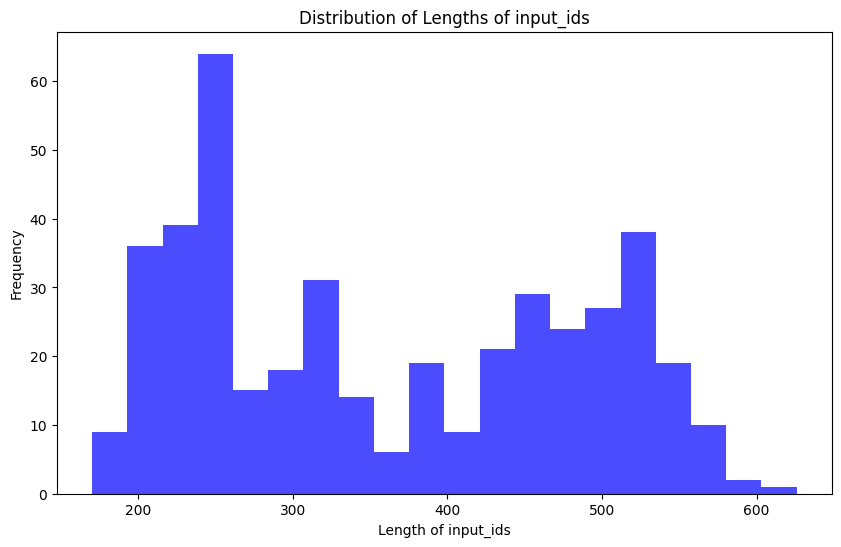

In [8]:
def plot_data_lengths(tokenize_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [9]:
max_length =650 # This was an appropriate max length for my dataset

def generate_and_tokenize_prompt(prompt):
    result = tokenizer(
        formatting_func(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

In [10]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_test_dataset = test_dataset.map(generate_and_tokenize_prompt)

Map:   0%|          | 0/301 [00:00<?, ? examples/s]

Map:   0%|          | 0/130 [00:00<?, ? examples/s]

In [11]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [12]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [13]:
print(model)

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )
    )
   

In [14]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MistralForCausalLM(
      (model): MistralModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
                (base_layer): Lin

In [15]:
print_trainable_parameters(model)

trainable params: 85041152 || all params: 3837112320 || trainable%: 2.2162799758751914


In [16]:
import transformers
from datetime import datetime

project = "Mail_Finetune"
base_model_name = "Mistral"
run_name = base_model_name + "-" + project
output_dir = "./" + run_name

training_args = transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=1,
        per_device_train_batch_size=4,
        gradient_accumulation_steps=1,
        gradient_checkpointing=True,
        max_steps=500,
        learning_rate=2.5e-5, # Want a small lr for finetuning
        fp16=True,
        optim="paged_adamw_8bit",
        logging_steps=25,              # When to start reporting loss
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=25,                # Save checkpoints every 50 steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=25,               # Evaluate and save checkpoints every 50 steps
        do_eval=True,                # Perform evaluation at the end of training
        report_to="wandb",           # Comment this out if you don't want to use weights & baises
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"          # Name of the W&B run (optional)
    )

In [ ]:
trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args= training_args,
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss
25,1.051900,0.714089
50,0.547200,0.484945
75,0.387000,0.393924
100,0.285200,0.361462
125,0.234100,0.352136
150,0.197100,0.340584


/opt/conda/lib/python3.10/site-packages/peft/utils/save_and_load.py:131: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/peft/utils/save_and_load.py:131: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scala

In [58]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM,  BitsAndBytesConfig

base_model_id = "mistralai/Mistral-7B-v0.1"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",  
    bnb_4bit_compute_dtype=torch.bfloat16
)
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16
)

tokenizer = AutoTokenizer.from_pretrained(base_model_id, add_bos_token=True, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained("/kaggle/working/Mistral_Mail_Finetune/checkpoint-50", quantization_config=bnb_config)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [63]:
eval_prompt =   f"### The following is a promotional mail for our customer in a relationship: "
model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ftmodel.eval()
with torch.no_grad():
    print(tokenizer.decode(model.generate(**model_input, max_new_tokens=250, repetition_penalty=1)[0], skip_special_tokens = True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


### The following is a promotional mail for our customer in a relationship:  Love is in the Air: Celebrate Your Love with [Your Telecom Company Name]

Love is in the air, and we're here to make sure you and your partner celebrate it in style! At [Your Telecom Company Name], we believe that love deserves to be celebrated, and we're here to help you do just that.

Here's why [Your Telecom Company Name] is the perfect partner for your romantic journey:

Unlimited Connection: Our telecom services ensure you and your partner stay connected, no matter where you are.

Romantic Playlists: Access romantic playlists to set the mood for your special moments.

Date Night Ideas: Get inspired with date night ideas and romantic getaways.

Exclusive Discounts: Enjoy exclusive discounts on romantic getaways and experiences.

Love Support: Our dedicated love support team is here to help you through any romantic challenges.

Love is a beautiful journey, and we're here to make it even more special. Click 